In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KernelDensity
from datetime import datetime, date


In [3]:
# Read Theft data, add month and year columns
fulldf = pd.read_pickle('../data/theft-street.p')
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Join with weather
weather = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")
fulldf = fulldf.merge(weather,how="inner",left_on="date",right_on="DATE")

df = fulldf[fulldf.year < 2016]

## Yearly counts

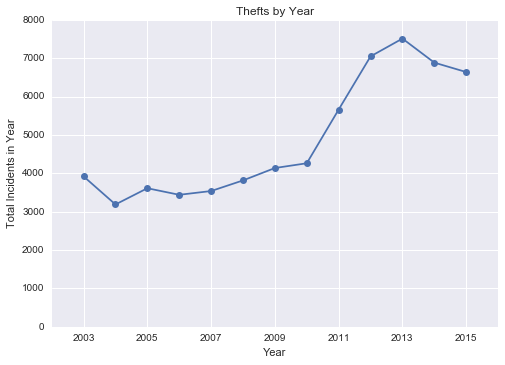

In [6]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title('Thefts by Year')
plt.axis([2002, 2016, 0, 8000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.savefig('plots/theft-yearlycounts.png')
pass

## Aggregated by month

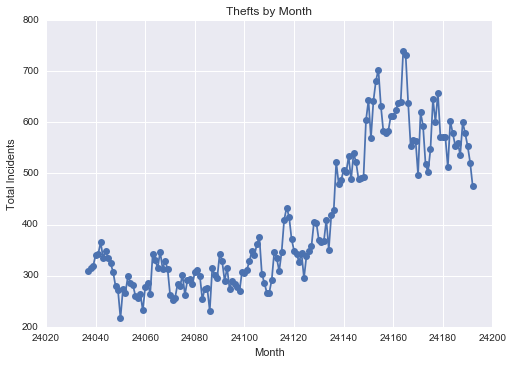

In [7]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title('Thefts by Month')
pass

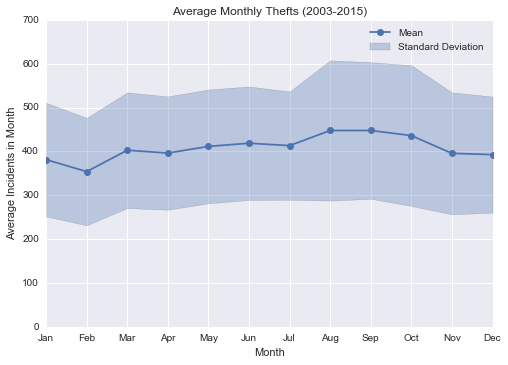

In [11]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})
plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly Thefts (2003-2015)')
plt.legend(['Mean','Standard Deviation'])
plt.axis([1, 12, 0, 700])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.savefig('plots/theft-monthlyaverage.png')
pass


## Aggregated by time of day

[0, 1440, 0, 0.002]

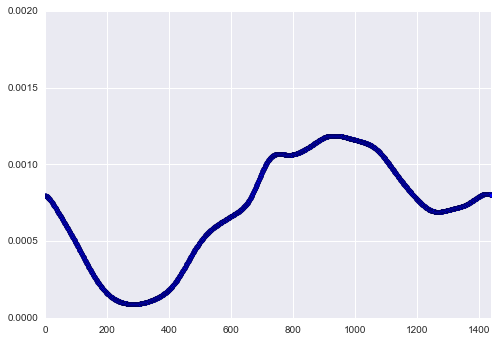

In [14]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
timegrid = np.arange(1,1440,1)
plt.scatter(timegrid, timekde.pdf(timegrid))
plt.axis([0, 1440, 0, 0.002])

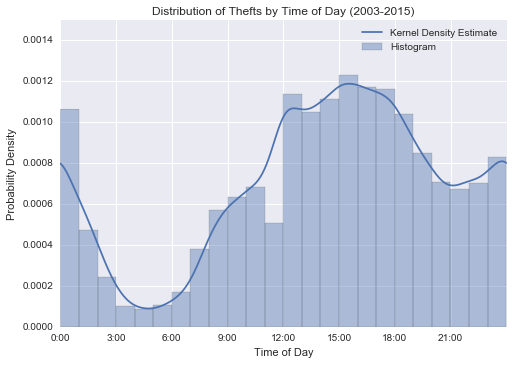

In [16]:
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color='#4C72B0')
plt.axis([0,1440,0,0.0015])
plt.xticks(range(0,1440,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of Thefts by Time of Day (2003-2015)')
plt.legend(['Kernel Density Estimate','Histogram'])
plt.savefig('plots/theft-timeofdaydistribution.png')
pass

## Aggregation by day of week

   dayofweek       std    sum       mean  size    stderr  dayofweekno
1     Monday  4.946297   7788  11.486726   678  0.189961            1
5    Tuesday  4.943504   8259  12.181416   678  0.189854            2
6  Wednesday  5.275725   8667  12.783186   678  0.202613            3
4   Thursday  5.592381   8920  13.136966   679  0.214616            4
0     Friday  6.657071  10422  15.371681   678  0.255663            5
2   Saturday  7.705901  10802  15.932153   678  0.295943            6
3     Sunday  7.174572   8814  13.019202   677  0.275741            7


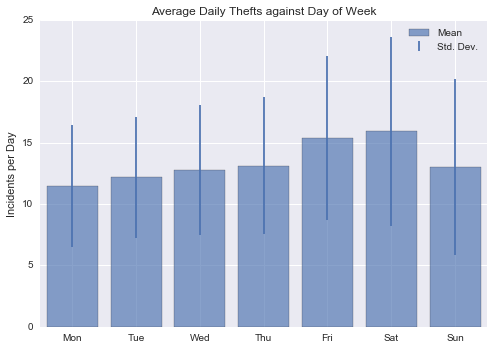

In [19]:
groupbydate = df[['date','dayofweek']].groupby(by=['date','dayofweek']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbyweekday = groupbydate.groupby(by='dayofweek')
#groupbyweekday = groupbyweekday['count'].agg(['size','sum','mean','std'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
}
groupbyweekday['dayofweekno'] = groupbyweekday['dayofweek'].apply(lambda x: weekdayno[x])
groupbyweekday.sort_values(by='dayofweekno',inplace=True)
print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
plt.axis([0.5,7.5,0,25])
plt.title('Average Daily Thefts against Day of Week')
plt.ylabel('Incidents per Day')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper right')
plt.savefig('plots/theft-dayofweekaverage.png')
pass

## Aggregation by spatial location

In [20]:
def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0021432865060126414,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

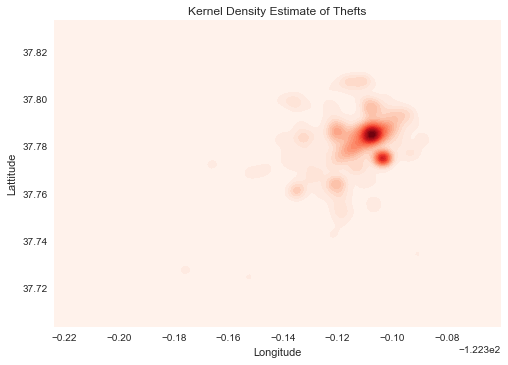

In [21]:
xmin = -122.5237517
xmax = -122.3602017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=200),np.linspace(ymin,ymax,num=200))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = np.exp(spacekde.score_samples(X_grid))
Z = Z.reshape(xv.shape)

levels = np.linspace(Z.min(), Z.max(), 25)
plt.contourf(xv, yv, Z, levels=levels, cmap=plt.cm.Reds)
plt.title('Kernel Density Estimate of Thefts')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.savefig('plots/theft-spatialkdeheatmap.png')

In [ ]:
def toheatarray(X,Z):
    return [[point[0], point[1], point[2]] for point in zip(X[:,0],X[:,1],Z)]

## Aggregation by precipitation

               std      sum       mean  size    stderr
PRCP                                                  
[0, 5)    6.351130  59311.0  13.637848  4349  0.096307
[5, 10)   5.662069   1951.0  11.544379   169  0.435544
[10, 15)  4.828142    914.0  10.880952    84  0.526794
[15, 20)  4.590540    489.0   9.780000    50  0.649200
[20, 25)  5.145830    319.0  10.290323    31  0.924218
[25, 30)  4.950494    310.0  10.689655    29  0.919284
[30, 35)  5.725465    196.0  13.066667    15  1.478309
[35, 40)  7.141428     50.0  10.000000     5  3.193744
[40, 45)       NaN     20.0  20.000000     1       NaN
[45, 50)  4.725816     34.0  11.333333     3  2.728451
[50, 55)  5.909033     27.0   6.750000     4  2.954516
[55, 60)  2.121320     19.0   9.500000     2  1.500000
[60, 65)       NaN      5.0   5.000000     1       NaN
[65, 70)       NaN      6.0   6.000000     1       NaN
[70, 75)       NaN      NaN        NaN     0       NaN
[75, 80)       NaN      NaN        NaN     0       NaN
[80, 85)  

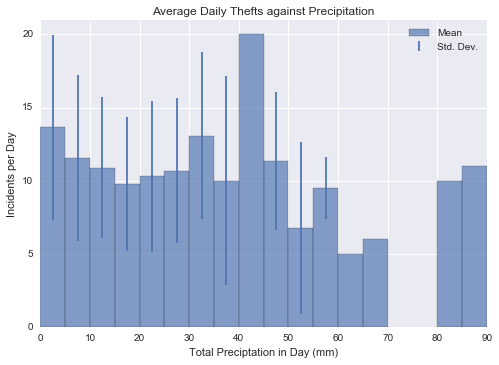

In [25]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbyprcp = groupbydate.groupby(pd.cut(groupbydate.PRCP,bins=range(0,91,5),right=False))
groupbyprcp = groupbyprcp['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyprcp['stderr'] = groupbyprcp.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbyprcp

p = plt.bar(left=np.arange(0,90,5),
           height=groupbyprcp['mean'].as_matrix(),
           width=5,
           yerr = groupbyprcp['std'],
           alpha=0.66)
plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Thefts against Precipitation')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper right')
plt.axis([0,90,0,21])
plt.savefig('plots/theft-precipaverage.png')


## Aggregation by TMAX

In [26]:
def celsius2fahrenheit(T):
    return T * 1.8 + 32

In [27]:
df.TMAX.apply(celsius2fahrenheit).describe()

count    63672.000000
mean        64.489005
std          7.317342
min         44.060000
25%         60.080000
50%         64.040000
75%         68.000000
max         98.060000
Name: TMAX, dtype: float64

                std    sum       mean  size    stderr
TMAX                                                 
[40, 45)   6.244998     39  13.000000     3  3.605551
[45, 50)   6.198576    400  12.121212    33  1.079034
[50, 55)   5.716551   3127  11.496324   272  0.346617
[55, 60)   5.700151  11637  12.432692   936  0.186315
[60, 65)   6.233218  23962  13.334446  1797  0.147041
[65, 70)   6.599981  14422  14.307540  1008  0.207880
[70, 75)   6.666767   4458  15.319588   291  0.390813
[75, 80)   7.159747   2963  14.383495   206  0.498843
[80, 85)   5.976647   1534  13.111111   117  0.552541
[85, 90)   5.784860    779  13.910714    56  0.773034
[90, 95)   8.493892    255  13.421053    19  1.948632
[95, 100)  3.703280     96  12.000000     8  1.309307


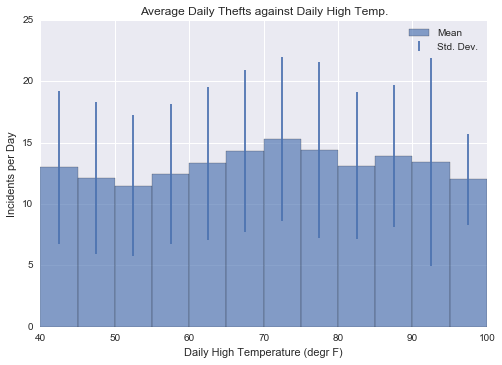

In [29]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbydate['TMAX'] = groupbydate.TMAX.apply(celsius2fahrenheit)
groupbytmax = groupbydate.groupby(pd.cut(groupbydate.TMAX,bins=range(40,101,5),right=False))
groupbytmax = groupbytmax['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmax['stderr'] = groupbytmax.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmax


p = plt.bar(left=np.arange(40,100,5),
           height=groupbytmax['mean'].as_matrix(),
           width=5,
           yerr = groupbytmax['std'],
           alpha=0.66)
plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Thefts against Daily High Temp.')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'])
plt.axis([40,100,0,25])
plt.savefig('plots/theft-tmaxaverage.png')
pass

## Aggregation by TMIN

In [ ]:
df.TMIN.apply(celsius2fahrenheit).describe()

               std    sum       mean  size    stderr
TMIN                                                
[35, 40)  4.870166    616  11.200000    55  0.196225
[40, 45)  6.092314   5203  12.358670   421  0.084461
[45, 50)  5.737372  13410  12.662890  1059  0.049545
[50, 55)  6.236247  27982  13.369326  2093  0.037281
[55, 60)  6.711745  13798  14.402923   958  0.057138
[60, 65)  7.479431   2627  16.839744   156  0.145928
[65, 70)  1.414214     36   9.000000     4  0.235702


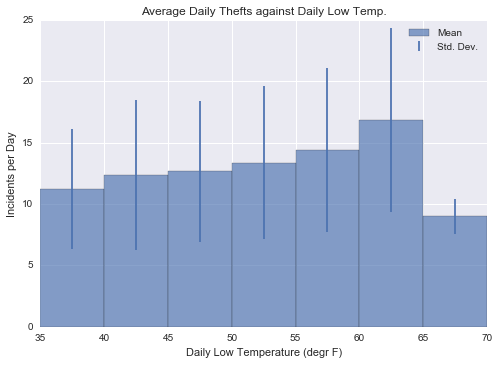

In [31]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbydate['TMIN'] = groupbydate.TMIN.apply(celsius2fahrenheit)
groupbytmin = groupbydate.groupby(pd.cut(groupbydate.TMIN,bins=range(35,71,5),right=False))
groupbytmin = groupbytmin['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmin['stderr'] = groupbytmin.apply(lambda row: row['std']/np.sqrt(row['sum']),axis=1)
print groupbytmin
p = plt.bar(left=np.arange(35,70,5),
           height=groupbytmin['mean'].as_matrix(),
           width=5,
           yerr = groupbytmin['std'],
           alpha=0.66)
plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Thefts against Daily Low Temp.')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='best')
plt.axis([35,70,0,25])
plt.savefig('plots/theft-tminaverage.png')
pass